In [1]:
import cv2
import numpy as np
import imutils
import tensorflow as tf

In [2]:
# loading the dataset

def read_csv(csv_file_path):
  with open(csv_file_path, 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    return [(row[0], row[1]) for row in csv_reader if len(row) > 0]

def train_val_split(train_paths, val_size):
  random.shuffle(train_paths)
  len_train_paths = len(train_paths)
  i = int(len_train_paths*(1.0 - val_size))
  train = train_paths[0:i]
  val = train_paths[i:len(train_paths)]
  return train, val

def load_train_paths(train_path):
  train_paths = read_csv(train_path)
  labels = {img_path: dm_path for img_path, dm_path in train_paths}
  x_paths = [img_path for img_path, dm in train_paths]
  x_train_paths, x_val_paths = train_val_split(x_paths, 0.3)

  partition = {
    'train': x_train_paths,
    'validation': x_val_paths
  }
  return partition, labels

In [3]:
def normalize_img(img):
    norm_img = (img - img.min()) / (img.max() - img.min())
    return norm_img

def preprocess_image(img_path, horizontal_flip=False):
    image = cv2.imread(img_path)
    image = imutils.resize(image, height=240)  # Resize height to 240
    image = cv2.resize(image, (640, 240))  # Ensure width is 320
    image = image.astype("float")
    image = normalize_img(image)

    if horizontal_flip:
        image = cv2.flip(image, 1)
    return image

def preprocess_depth_map(depth_map_path, horizontal_flip=False):
    depth_map = cv2.imread(depth_map_path)
    depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
    depth_map = imutils.resize(depth_map, height=240)  # Resize height to 240
    depth_map = cv2.resize(depth_map, (640, 240))  # Ensure width is 320
    depth_map = depth_map.astype("float")
    depth_map = normalize_img(depth_map)

    if horizontal_flip:
        depth_map = cv2.flip(depth_map, 1)

    depth_map = np.reshape(depth_map, (depth_map.shape[0], depth_map.shape[1], 1))
    return depth_map


In [4]:
import csv

img_dm_pairs = read_csv('/kaggle/input/kitti-csv-train-gt/kitti_test_mapping.csv')
labels = {i: j for i,j in img_dm_pairs}
test_paths = [i for i,j in img_dm_pairs]
print(len(test_paths))
partition = {'test': test_paths}

200


In [5]:
x_test = np.empty((len(test_paths), 240, 640, 3))
y_test = np.empty((len(test_paths), 240, 640, 1))

for i, ID in enumerate(partition['test'][:]):
  x_test[i, ] = preprocess_image(ID, horizontal_flip=False)
  y_test[i, ] = preprocess_depth_map(labels[ID], horizontal_flip=False)

In [6]:
import matplotlib.pyplot as plt
# plt.imshow(test_paths[0])
print(test_paths[0])

/kaggle/input/kitti-3d-object-detection-dataset/training/image_2/007281.png


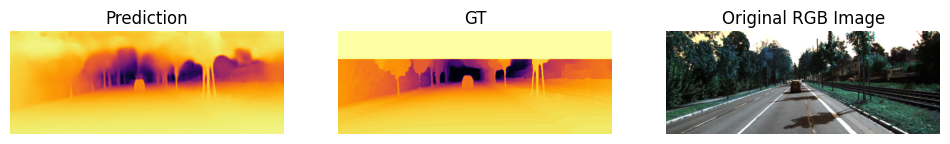

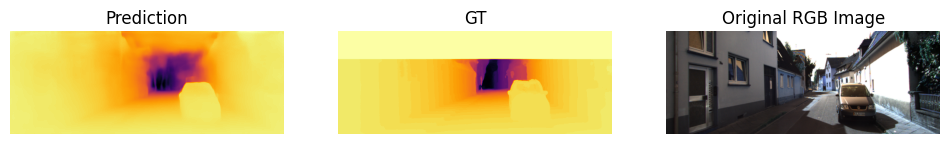

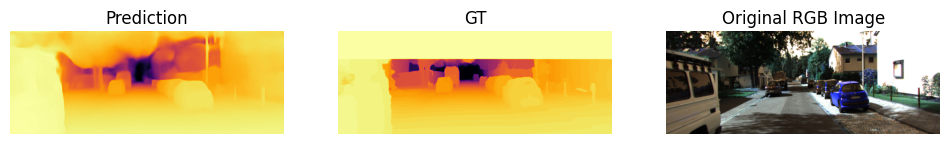

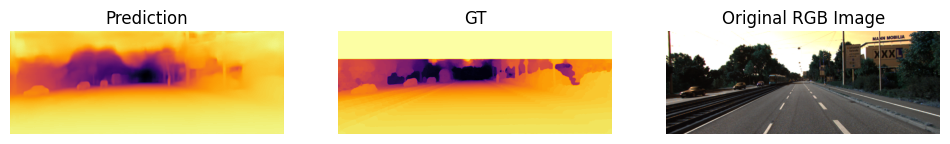

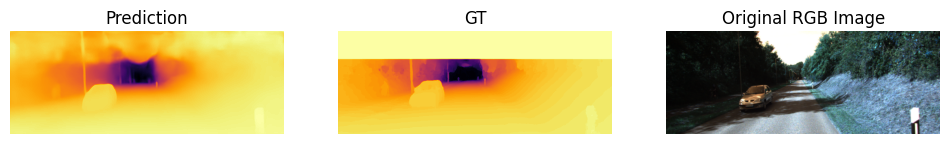

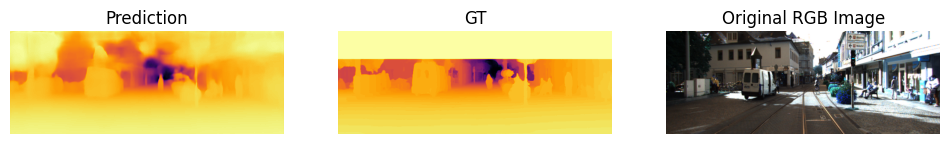

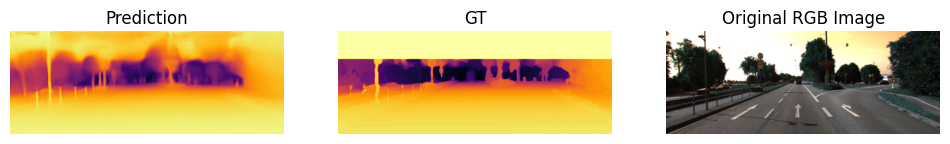

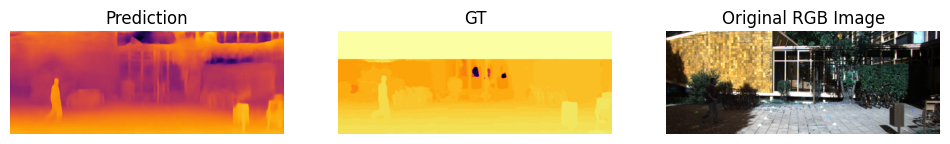

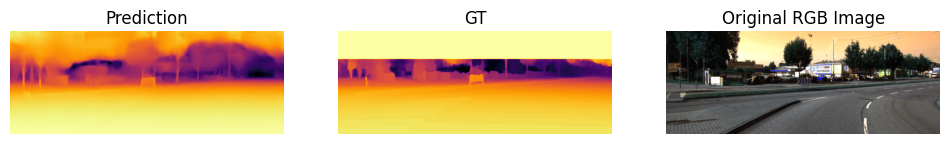

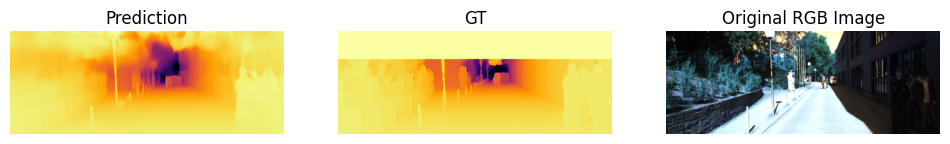

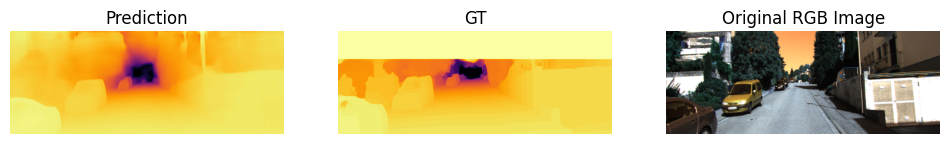

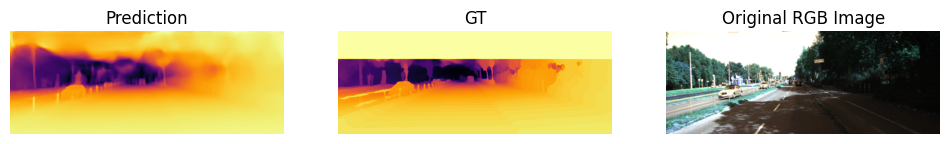

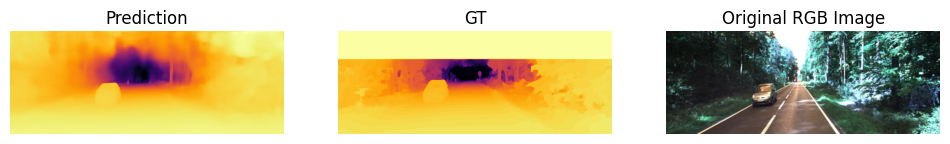

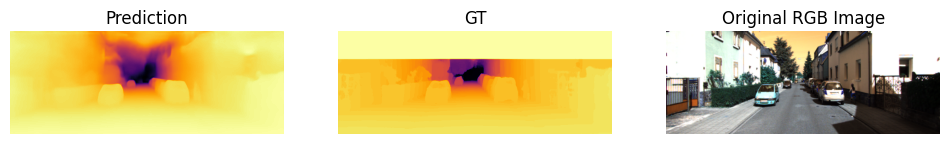

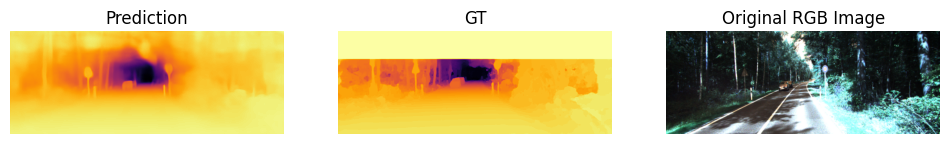

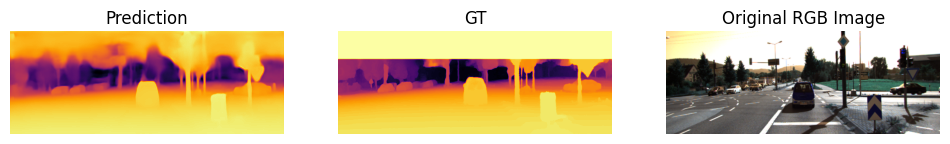

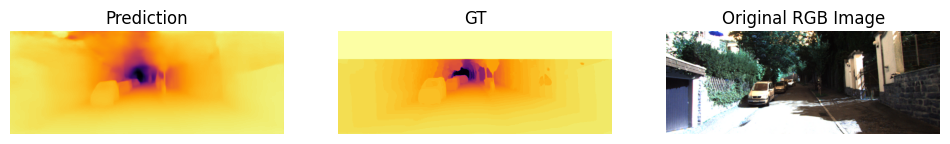

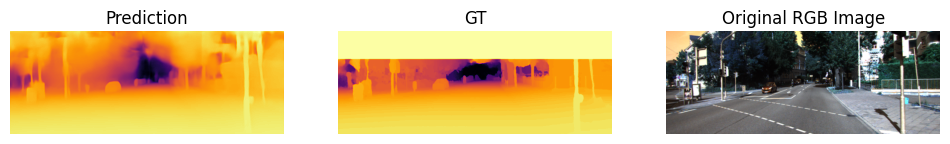

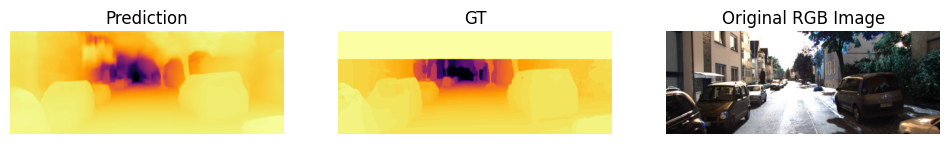

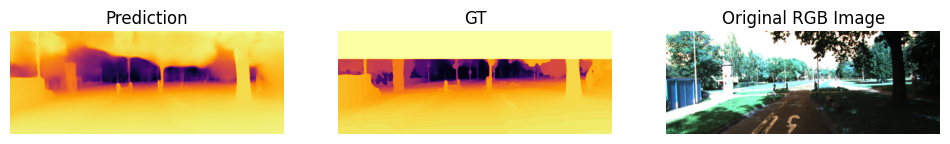

Average inference time per image for (inp dim 1242 x 375): 9.8274 seconds


In [12]:
import time
from transformers import AutoImageProcessor, DPTForDepthEstimation
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

# Assuming you have a `test_paths` list and `labels` dictionary
image_processor = AutoImageProcessor.from_pretrained("facebook/dpt-dinov2-small-kitti")
model = DPTForDepthEstimation.from_pretrained("facebook/dpt-dinov2-small-kitti")
# Make sure the model is in evaluation mode
model.eval()

# Initialize variables to calculate total inference time
total_inference_time = 0
num_images = len(test_paths) - 180  # Number of images to process

for i in range(num_images):
    # Load the test image and its corresponding label
    path = test_paths[i]
    label_path = labels[path]
    
    # Preprocess the image using the processor
    image = Image.open(path)
    # print(image.size)
    # image = cv2.resize(image, (640, 240)) # Ensure width is 320
    # image = image.resize((320, 240))
    inputs = image_processor(images=image, return_tensors="pt")
    
    # Measure inference time
    start_time = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    end_time = time.time()
    
    # Calculate and accumulate inference time
    inference_time = end_time - start_time
    total_inference_time += inference_time

    pred = outputs.predicted_depth
    
    # Interpolate to original size
    prediction = torch.nn.functional.interpolate(
        pred.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )
    output = prediction.squeeze().cpu().numpy()  # Get predicted depth as NumPy array
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    # print("After:",depth.size)
    new_size = (640, 240)
    resize_pred = depth.resize(new_size)
    
    # Preprocess the label image (ground truth depth map)
    gt_img = preprocess_depth_map(label_path, horizontal_flip=False)
    gt_img = np.squeeze(gt_img, axis=-1)  # Remove the extra dimension
    
    # Preprocess the original RGB image
    img1 = preprocess_image(path, horizontal_flip=False)
    
    # Plot the images
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.title("Prediction")
    plt.imshow(resize_pred, cmap='inferno_r')  # Use 'inferno_r' colormap for depth visualization
    
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.title("GT")
    plt.imshow(gt_img, cmap='inferno_r')  # Ground truth depth map
    
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.title("Original RGB Image")
    plt.imshow(img1)  # Original RGB image
    
    plt.show()

# Calculate the average inference time
average_inference_time = total_inference_time / num_images
print(f"Average inference time per image for (inp dim 1242 x 375): {average_inference_time:.4f} seconds")


(1242, 375)


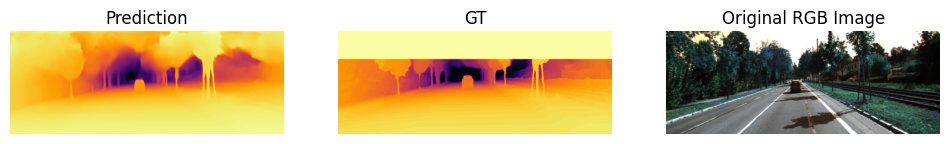

(1242, 375)


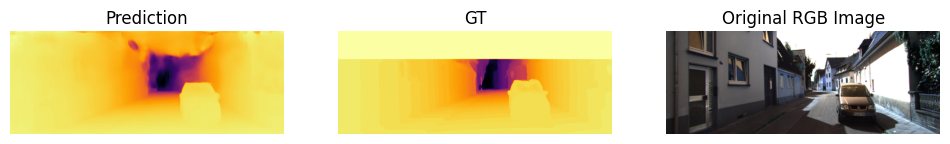

(1242, 375)


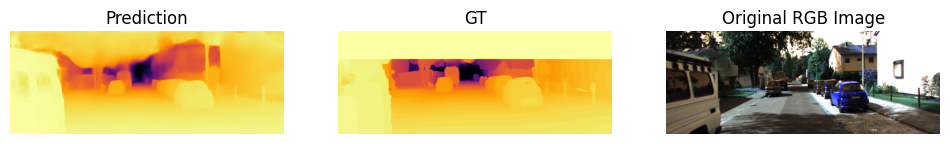

(1242, 375)


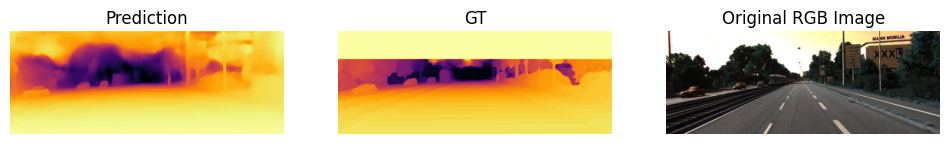

(1242, 375)


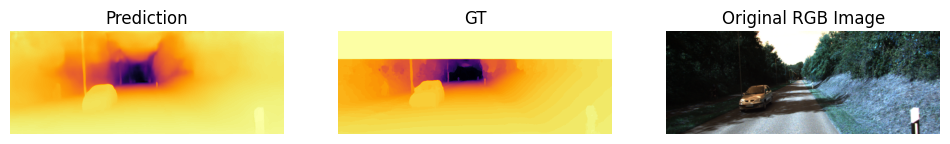

(1242, 375)


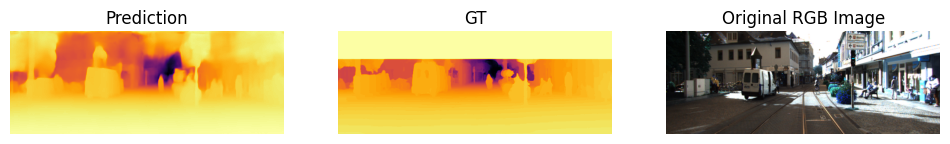

(1242, 375)


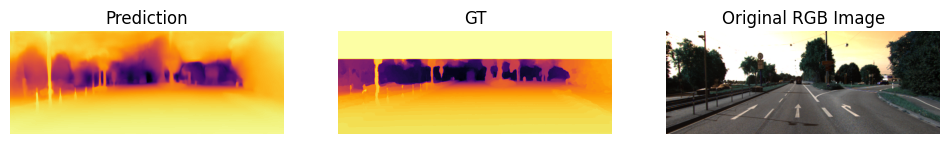

(1224, 370)


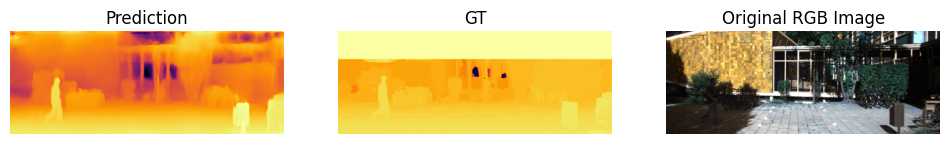

(1242, 375)


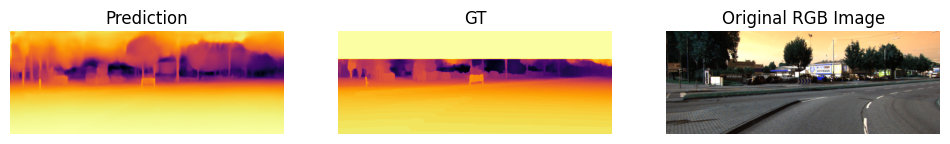

(1224, 370)


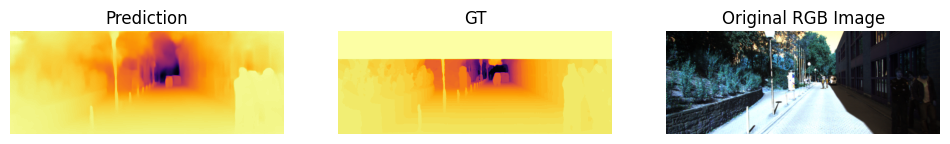

Average inference time per image: 14.1417 seconds


In [59]:
import time
from transformers import AutoImageProcessor, DPTForDepthEstimation
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

# Assuming you have a `test_paths` list and `labels` dictionary
image_processor = AutoImageProcessor.from_pretrained("facebook/dpt-dinov2-base-kitti")
model = DPTForDepthEstimation.from_pretrained("facebook/dpt-dinov2-base-kitti")
# Make sure the model is in evaluation mode
model.eval()

# Initialize variables to calculate total inference time
total_inference_time = 0
num_images = len(test_paths) - 190  # Number of images to process

for i in range(num_images):
    # Load the test image and its corresponding label
    path = test_paths[i]
    label_path = labels[path]
    
    # Preprocess the image using the processor
    image = Image.open(path)
    # image = image.resize((320, 240))
    # print(image.size)
    inputs = image_processor(images=image, return_tensors="pt")
    
    # Measure inference time
    start_time = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    end_time = time.time()
    
    # Calculate and accumulate inference time
    inference_time = end_time - start_time
    total_inference_time += inference_time

    pred = outputs.predicted_depth

    # Interpolate to original size
    prediction = torch.nn.functional.interpolate(
        pred.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )
    output = prediction.squeeze().cpu().numpy()  # Get predicted depth as NumPy array
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    new_size = (640, 240)
    resize_pred = depth.resize(new_size)
    
    # Preprocess the label image (ground truth depth map)
    gt_img = preprocess_depth_map(label_path, horizontal_flip=False)
    gt_img = np.squeeze(gt_img, axis=-1)  # Remove the extra dimension
    
    # Preprocess the original RGB image
    img1 = preprocess_image(path, horizontal_flip=False)
    
    # Plot the images
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.title("Prediction")
    plt.imshow(resize_pred, cmap='inferno_r')  # Use 'inferno_r' colormap for depth visualization
    
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.title("GT")
    plt.imshow(gt_img, cmap='inferno_r')  # Ground truth depth map
    
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.title("Original RGB Image")
    plt.imshow(img1)  # Original RGB image
    
    plt.show()

# Calculate the average inference time
average_inference_time = total_inference_time / num_images
print(f"Average inference time per image: {average_inference_time:.4f} seconds")


In [60]:
# # Display model parameters
# total_params = sum(p.numel() for p in model.parameters())
# trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# non_trainable_params = total_params - trainable_params

# print(f"Total parameters: {total_params}")
# print(f"Trainable parameters: {trainable_params}")
# print(f"Non-trainable parameters: {non_trainable_params}")


(1242, 375)


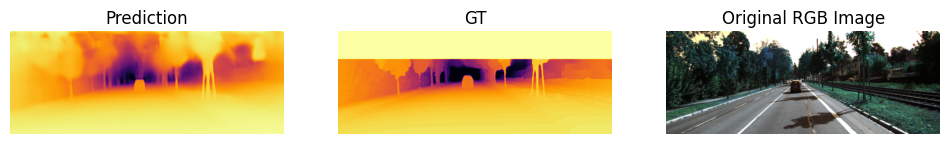

(1242, 375)


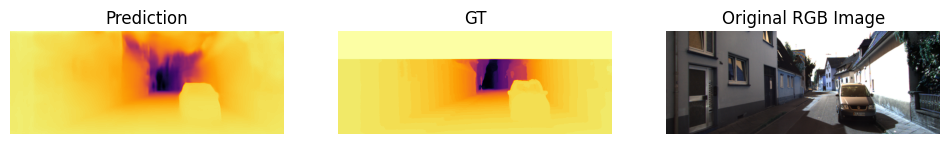

(1242, 375)


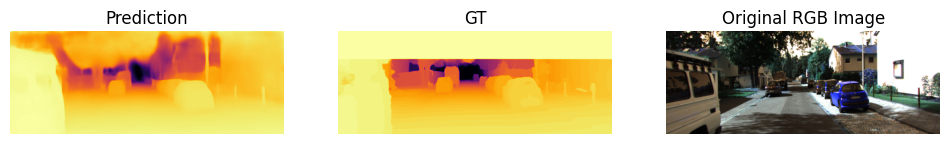

(1242, 375)


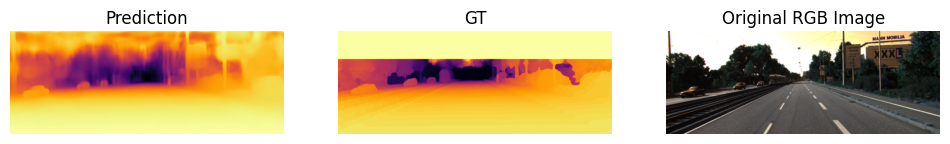

(1242, 375)


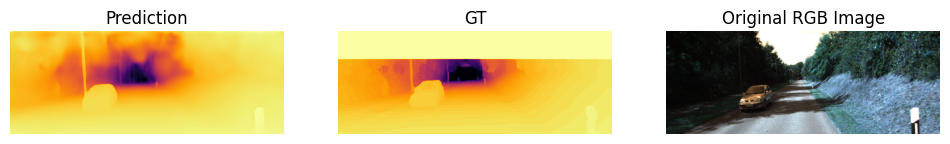

(1242, 375)


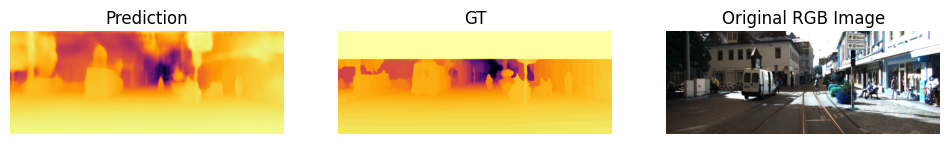

(1242, 375)


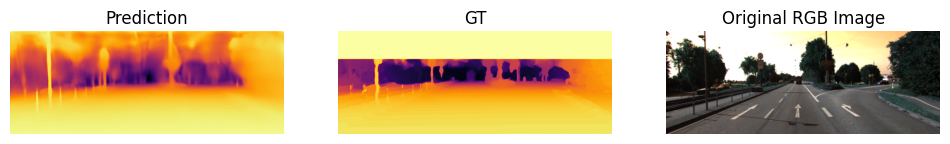

(1224, 370)


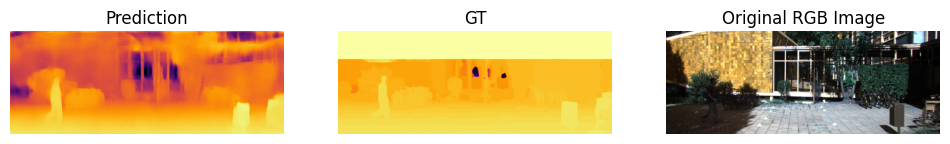

(1242, 375)


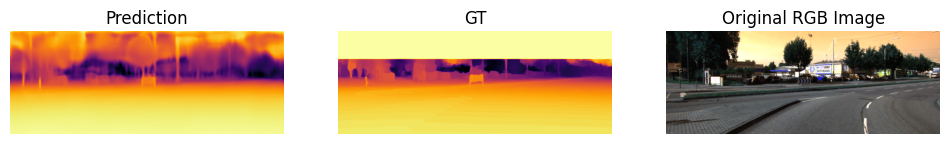

(1224, 370)


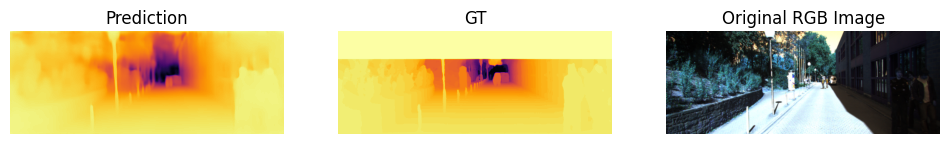

Average inference time per image: 31.3206 seconds


In [61]:
import time
from transformers import AutoImageProcessor, DPTForDepthEstimation
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

# Assuming you have a `test_paths` list and `labels` dictionary
image_processor = AutoImageProcessor.from_pretrained("facebook/dpt-dinov2-large-kitti")
model = DPTForDepthEstimation.from_pretrained("facebook/dpt-dinov2-large-kitti")
# Make sure the model is in evaluation mode
model.eval()

# Initialize variables to calculate total inference time
total_inference_time = 0
num_images = len(test_paths) - 190  # Number of images to process

for i in range(num_images):
    # Load the test image and its corresponding label
    path = test_paths[i]
    label_path = labels[path]
    
    # Preprocess the image using the processor
    image = Image.open(path)
    # image = image.resize((320, 240))
    print(image.size)
    inputs = image_processor(images=image, return_tensors="pt")
    
    # Measure inference time
    start_time = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    end_time = time.time()
    
    # Calculate and accumulate inference time
    inference_time = end_time - start_time
    total_inference_time += inference_time

    pred = outputs.predicted_depth

    # Interpolate to original size
    prediction = torch.nn.functional.interpolate(
        pred.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )
    output = prediction.squeeze().cpu().numpy()  # Get predicted depth as NumPy array
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    new_size = (640, 240)
    resize_pred = depth.resize(new_size)
    
    # Preprocess the label image (ground truth depth map)
    gt_img = preprocess_depth_map(label_path, horizontal_flip=False)
    gt_img = np.squeeze(gt_img, axis=-1)  # Remove the extra dimension
    
    # Preprocess the original RGB image
    img1 = preprocess_image(path, horizontal_flip=False)
    
    # Plot the images
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.title("Prediction")
    plt.imshow(resize_pred, cmap='inferno_r')  # Use 'inferno_r' colormap for depth visualization
    
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.title("GT")
    plt.imshow(gt_img, cmap='inferno_r')  # Ground truth depth map
    
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.title("Original RGB Image")
    plt.imshow(img1)  # Original RGB image
    
    plt.show()

# Calculate the average inference time
average_inference_time = total_inference_time / num_images
print(f"Average inference time per image: {average_inference_time:.4f} seconds")


In [62]:
# # Display model parameters
# total_params = sum(p.numel() for p in model.parameters())
# trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# non_trainable_params = total_params - trainable_params

# print(f"Total parameters: {total_params}")
# print(f"Trainable parameters: {trainable_params}")
# print(f"Non-trainable parameters: {non_trainable_params}")


(1242, 375)


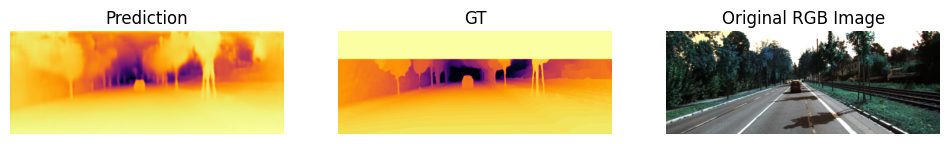

(1242, 375)


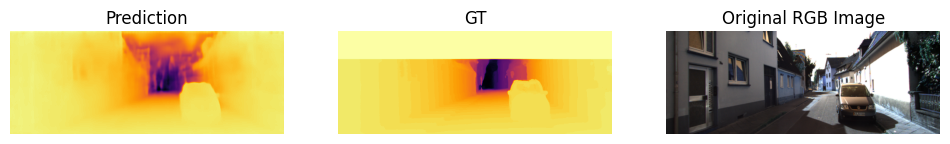

(1242, 375)


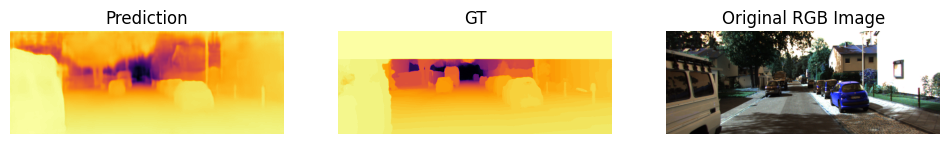

(1242, 375)


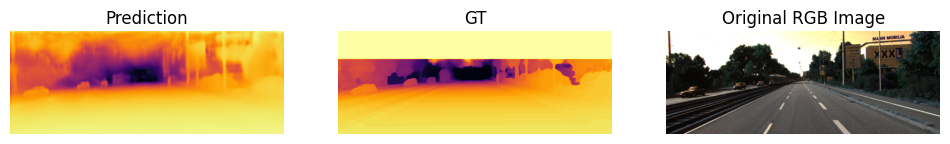

(1242, 375)


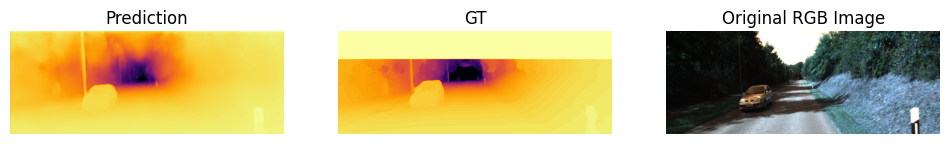

(1242, 375)


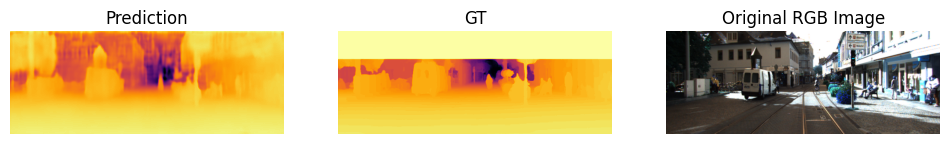

(1242, 375)


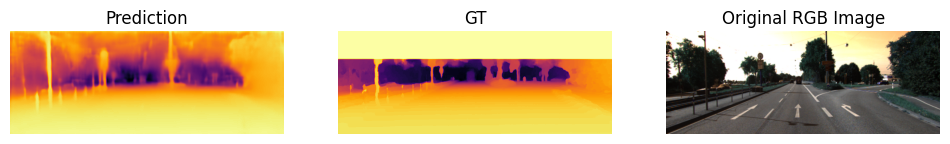

(1224, 370)


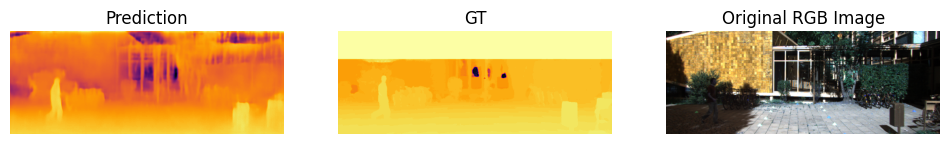

(1242, 375)


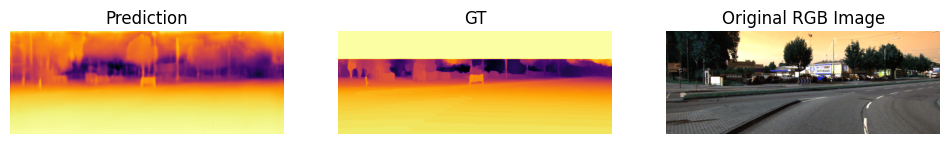

(1224, 370)


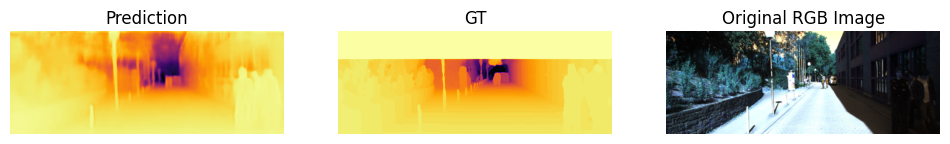

Average inference time per image: 76.1996 seconds


In [63]:
import time
from transformers import AutoImageProcessor, DPTForDepthEstimation
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

# Assuming you have a `test_paths` list and `labels` dictionary
image_processor = AutoImageProcessor.from_pretrained("facebook/dpt-dinov2-giant-kitti")
model = DPTForDepthEstimation.from_pretrained("facebook/dpt-dinov2-giant-kitti")
# Make sure the model is in evaluation mode
model.eval()

# Initialize variables to calculate total inference time
total_inference_time = 0
num_images = len(test_paths) - 190  # Number of images to process

for i in range(num_images):
    # Load the test image and its corresponding label
    path = test_paths[i]
    label_path = labels[path]
    
    # Preprocess the image using the processor
    image = Image.open(path)
    # image = image.resize((320, 240))
    print(image.size)
    inputs = image_processor(images=image, return_tensors="pt")
    
    # Measure inference time
    start_time = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    end_time = time.time()
    
    # Calculate and accumulate inference time
    inference_time = end_time - start_time
    total_inference_time += inference_time

    pred = outputs.predicted_depth

    # Interpolate to original size
    prediction = torch.nn.functional.interpolate(
        pred.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )
    output = prediction.squeeze().cpu().numpy()  # Get predicted depth as NumPy array
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    new_size = (640, 240)
    resize_pred = depth.resize(new_size)
    
    # Preprocess the label image (ground truth depth map)
    gt_img = preprocess_depth_map(label_path, horizontal_flip=False)
    gt_img = np.squeeze(gt_img, axis=-1)  # Remove the extra dimension
    
    # Preprocess the original RGB image
    img1 = preprocess_image(path, horizontal_flip=False)
    
    # Plot the images
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.title("Prediction")
    plt.imshow(resize_pred, cmap='inferno_r')  # Use 'inferno_r' colormap for depth visualization
    
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.title("GT")
    plt.imshow(gt_img, cmap='inferno_r')  # Ground truth depth map
    
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.title("Original RGB Image")
    plt.imshow(img1)  # Original RGB image
    
    plt.show()

# Calculate the average inference time
average_inference_time = total_inference_time / num_images
print(f"Average inference time per image: {average_inference_time:.4f} seconds")


# **Model's complexity**

In [14]:
!pip install thop


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [19]:
from thop import profile
from transformers import AutoImageProcessor, DPTForDepthEstimation
import torch
from PIL import Image

# Load model and image processor
image_processor = AutoImageProcessor.from_pretrained("facebook/dpt-dinov2-small-kitti")
model = DPTForDepthEstimation.from_pretrained("facebook/dpt-dinov2-small-kitti")
model.eval()

# Create a dummy input image with the required size
dummy_image = Image.new("RGB", (320, 240))  # Adjust dimensions as per your model's requirements
dummy_inputs = image_processor(images=dummy_image, return_tensors="pt")

# Calculate FLOPs and number of parameters using `thop`
flops, params = profile(model, inputs=(dummy_inputs['pixel_values'],))

# Print the results
print(f"FLOPs: {flops / 1e9:.2f} GFLOPs")  # Convert to GigaFLOPs
print(f"Parameters: {params / 1e6:.2f} M")  # Convert to Millions


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
FLOPs: 63.98 GFLOPs
Parameters: 35.48 M


In [20]:
from thop import profile
from transformers import AutoImageProcessor, DPTForDepthEstimation
import torch
from PIL import Image

# Load model and image processor
image_processor = AutoImageProcessor.from_pretrained("facebook/dpt-dinov2-base-kitti")
model = DPTForDepthEstimation.from_pretrained("facebook/dpt-dinov2-base-kitti")
model.eval()

# Create a dummy input image with the required size
dummy_image = Image.new("RGB", (320, 240))  # Adjust dimensions as per your model's requirements
dummy_inputs = image_processor(images=dummy_image, return_tensors="pt")

# Calculate FLOPs and number of parameters using `thop`
flops, params = profile(model, inputs=(dummy_inputs['pixel_values'],))

# Print the results
print(f"FLOPs: {flops / 1e9:.2f} GFLOPs")  # Convert to GigaFLOPs
print(f"Parameters: {params / 1e6:.2f} M")  # Convert to Millions


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
FLOPs: 95.06 GFLOPs
Parameters: 109.70 M


In [68]:
from thop import profile
from transformers import AutoImageProcessor, DPTForDepthEstimation
import torch
from PIL import Image

# Load model and image processor
image_processor = AutoImageProcessor.from_pretrained("facebook/dpt-dinov2-large-kitti")
model = DPTForDepthEstimation.from_pretrained("facebook/dpt-dinov2-large-kitti")
model.eval()

# Create a dummy input image with the required size
dummy_image = Image.new("RGB", (320, 240))  # Adjust dimensions as per your model's requirements
dummy_inputs = image_processor(images=dummy_image, return_tensors="pt")

# Calculate FLOPs and number of parameters using `thop`
flops, params = profile(model, inputs=(dummy_inputs['pixel_values'],))

# Print the results
print(f"FLOPs: {flops / 1e9:.2f} GFLOPs")  # Convert to GigaFLOPs
print(f"Parameters: {params / 1e6:.2f} M")  # Convert to Millions


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
FLOPs: 189.44 GFLOPs
Parameters: 337.10 M


In [69]:
from thop import profile
from transformers import AutoImageProcessor, DPTForDepthEstimation
import torch
from PIL import Image

# Load model and image processor
image_processor = AutoImageProcessor.from_pretrained("facebook/dpt-dinov2-giant-kitti")
model = DPTForDepthEstimation.from_pretrained("facebook/dpt-dinov2-giant-kitti")
model.eval()

# Create a dummy input image with the required size
dummy_image = Image.new("RGB", (320, 240))  # Adjust dimensions as per your model's requirements
dummy_inputs = image_processor(images=dummy_image, return_tensors="pt")

# Calculate FLOPs and number of parameters using `thop`
flops, params = profile(model, inputs=(dummy_inputs['pixel_values'],))

# Print the results
print(f"FLOPs: {flops / 1e9:.2f} GFLOPs")  # Convert to GigaFLOPs
print(f"Parameters: {params / 1e6:.2f} M")  # Convert to Millions


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
FLOPs: 545.52 GFLOPs
Parameters: 1196.05 M
